# cut 1024 image into 512

In [1]:
import sys
# TODO replace path
sys.path.append('../../X_unet_yolo_combine/')
#from crop_image import image_padding, cut_image, joint_image

In [3]:
import glob, os
from PIL import Image
import numpy as np
import multiprocessing
from multiprocessing.pool import ThreadPool
import cv2
from sklearn.model_selection import train_test_split

In [4]:
os.getcwd()

'/data/jupyter-data/yinshan/U-net-tummor/VOCdevkit'

In [5]:
import shutil
from shutil import copytree, ignore_patterns
#shutil.copytree('../../IHC-datasets','./train_20230721_IHC_2.5x/JPEGImags_ori/',ignore=ignore_patterns('*_IHC*-labels.png'))

In [6]:
shutil.copytree('../../../../AP/Ki67-ER-PR/region/KEP-label/','./train_20230829/JPEGImags_ori/',ignore=ignore_patterns('*-labels.png'))

'./train_20230829/JPEGImags_ori/'

In [7]:
shutil.copytree('../../../../AP/Ki67-ER-PR/region/KEP-label/','./train_20230829/SegmentationClass_ori',ignore=ignore_patterns('*.jpeg'))

'./train_20230829/SegmentationClass_ori'

In [8]:
shutil.rmtree('./train_20230824/JPEGImags_ori/KEP-label/',ignore_errors=True)

In [8]:
# TODO specify directory
base_folder = 'train_20230829/'

In [9]:
# 1024 folder
mask_path = 'SegmentationClass_ori'
image_path = 'JPEGImags_ori/'

In [10]:
masks_files = glob.glob(os.path.join(base_folder, mask_path, '*.png'))

In [11]:
len(masks_files)

1345

In [12]:
image_files=glob.glob(os.path.join(base_folder, image_path, '*.jpeg'))

In [13]:
len(image_files)

1345

In [14]:
img_files = []
for file in masks_files:
    base = os.path.splitext(os.path.basename(file))[0]
    img = []
    # base = base.replace('-labels', '')
    img = glob.glob(os.path.join(base_folder, image_path, base + '.png'))
    if len(img) == 0:
        img = glob.glob(os.path.join(base_folder, image_path, base.replace('-labels', '') + '.jpeg'))
        img_files.append(img[0])
    else:
        img_files.append(img[0])

In [15]:
len(img_files), len(masks_files)

(1345, 1345)

In [16]:
img_files, masks_files

(['train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_100_20480_12288.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_101_22528_12288.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_102_24576_12288.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_107_4096_14336.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_108_6144_14336.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_109_8192_14336.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_110_10240_14336.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_111_12288_14336.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_123_6144_16384.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_124_8192_16384.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_125_10240_16384.jpeg',
  'train_20230829/JPEGImags_ori/patch_1_12023-08-02_08_37_51_126_12288_16384.jpeg

In [17]:
save_dir_img, save_dir_mask = 'JPEGImages', 'SegmentationClass'

In [18]:
os.makedirs(os.path.join(base_folder, save_dir_img), exist_ok=True)
os.makedirs(os.path.join(base_folder, save_dir_mask), exist_ok=True)

In [37]:
import matplotlib.pyplot as plt

In [44]:
mask_tmp = Image.open('./train_20230829/SegmentationClass/patch_1_102023-08-02_08_54_08_337_26624_18432_1.png')

In [45]:
mask_tmp_arr = np.array(mask_tmp)
#mask_tmp_arr= cv2.cvtColor(mask_tmp_arr, cv2.COLOR_BGR2GRAY)
#mask_tmp_arr=mask_tmp_arr/255

In [46]:
np.bincount(mask_tmp_arr.reshape(-1))

array([257193,   4951])

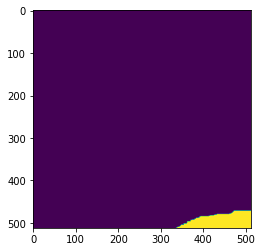

In [47]:
plt.imshow(mask_tmp_arr)

In [48]:
mask_tmp_arr.shape

(512, 512)

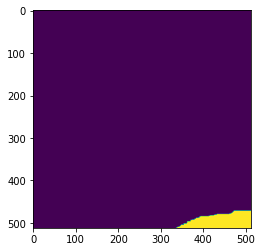

In [49]:
plt.imshow(mask_tmp_arr==1)

In [19]:
def cut_image(image, col, row, item_width, return_images=True):
    if isinstance(image, Image.Image):
        width, height = image.size
    elif isinstance(image, np.ndarray):
        width, height = image.shape[1], image.shape[0]
        image = image.copy()
    else:
        raise ValueError("Incorrect input image type")
    box_list = []
    count = 0
    for j in range(0, row):
        for i in range(0, col):
            count += 1
            xMin, yMin, xMax, yMax = i * item_width, j * item_width, (i + 1) * item_width, (j+1) * item_width
            if j == row-1:
                yMax = height
            if i == col-1:
                xMax = width
            box = (xMin, yMin, xMax, yMax)
            if xMax-xMin == item_width and yMax-yMin==item_width:
                box_list.append(box)
    if return_images:
        if isinstance(image, Image.Image):
            image_list = [image.crop(box) for box in box_list]
        elif isinstance(image, np.ndarray):
            image_list = [image[box[1]:box[3], box[0]:box[2]] for box in box_list]
        return image_list
    else:
        return box

In [56]:
def cut_images(image, col, row, item_width, return_images=True):
    if isinstance(image, Image.Image):
        width, height = image.size
    elif isinstance(image, np.ndarray):
        width, height = image.shape[1], image.shape[0]
        image = image.copy()
    else:
        raise ValueError("Incorrect input image type")
    box_list = []
    count = 0
    for j in range(0, row):
        for i in range(0, col):
            count += 1
            xMin, yMin, xMax, yMax = i * item_width, j * item_width, (i + 1) * item_width, (j+1) * item_width
            if j == row-1:
                yMax = height
            if i == col-1:
                xMax = width
            box = (xMin, yMin, xMax, yMax)
            box_list.append(box)
    if return_images:
        if isinstance(image, Image.Image):
            image_list = [image.crop(box) for box in box_list]
        elif isinstance(image, np.ndarray):
            image_list = [image[box[1]:box[3], box[0]:box[2]] for box in box_list]
        return image_list
    else:
        return box

In [20]:
def image_padding(input_image, item_width, return_padded_image=True):
    """
    Pad an image with white background。
    Args:
        input_image: can be an PIL.Image.Image or numpy array
        item_width: int, patch width to be cut
        return_padded_image: boolean. If true, return padded image.
    Returns:
        image: padded image (only return when return_padded_image is true)
        col: how many columns after padding
        rows: how many rows after padding
    """
    if isinstance(input_image, Image.Image):
        #iw, ih = input_image.size
        iw = np.size(input_image,1)
        ih = np.size(input_image,0)
        col = int(np.ceil(iw/item_width))
        row = int(np.ceil(ih/item_width))  #网络的输入为正方形，所以item_width=item_height
        target_size = (int(col*item_width), int(row*item_width))
        if return_padded_image:
            image = Image.new('RGB', target_size, (255, 255, 255))
            image.paste(input_image, (0, 0))
            return image, col, row
        else:
            return col, row
    elif isinstance(input_image, np.ndarray):
        iw = input_image.shape[1]
        ih = input_image.shape[0]
        col = int(np.ceil(iw / item_width))
        row = int(np.ceil(ih / item_width))  # 网络的输入为正方形，所以item_width=item_height
        target_size = (int(row * item_width), int(col * item_width))
        if return_padded_image:
            image = np.ones(target_size + (3,), dtype='uint8') * 255
            image[:ih, :iw, :] = input_image
            return image, col, row
        else:
            return col, row
    else:
        raise ValueError("Incorrect input image type")

In [21]:
def cut512to256(files):
    image_file = files[0]
    mask_file = files[1]
    basename = os.path.splitext(os.path.basename(image_file))[0]
    img = Image.open(image_file)
    mask = Image.open(mask_file)
    image, col, row = image_padding(img, 512)
    image_list = cut_image(img, col, row, 512)
    mask_image, mask_col, mask_row = image_padding(mask, 512)
    #mask_images=np.array(mask)
    #mask_images= cv2.cvtColor(mask_images, cv2.COLOR_BGR2GRAY)
    #mask_images=mask_images/255
    mask_list = cut_image(mask, mask_col, mask_row, 512)
    #print(len(mask_list))
    idx = 0
    for img_new, mask_new in zip(image_list, mask_list):
        idx+=1
        if os.path.exists(os.path.join(base_folder, save_dir_img, '{}_{}.png'.format(basename, idx))) and os.path.exists(os.path.join(base_folder, save_dir_mask, '{}_{}.png'.format(basename, idx))):
            print(basename, idx)
            continue
        img_new.save(os.path.join(base_folder, save_dir_img, '{}_{}.png'.format(basename, idx)))
        mask_new.save(os.path.join(base_folder, save_dir_mask, '{}_{}.png'.format(basename, idx)))
        #cv2.imwrite(os.path.join(base_folder, save_dir_mask, '{}_{}.png'.format(basename, idx)), mask_new)
        #mask_arr = np.array(mask_new)
        #print(mask_arr)
        #cv2.imwrite(os.path.join(base_folder, save_dir_mask, '{}_{}.png'.format(basename, idx)), mask_arr)

In [22]:
image_files=glob.glob(os.path.join(base_folder, image_path, '*.png'))

In [23]:
pool = ThreadPool(multiprocessing.cpu_count()//2)
pool.map(cut512to256, list(zip(img_files,masks_files)))
pool.close()
pool.join()

In [24]:
mask_paths = 'SegmentationClass'
masks_filess=glob.glob(os.path.join(base_folder, mask_paths, '*.png'))

In [25]:
len(masks_filess) 

5380

删除文件夹图片

In [69]:
def removeFileInDir(sourceDir):
    for file in os.listdir(sourceDir):
        file=os.path.join(sourceDir,file) #必须拼接完整文件名
        if os.path.isfile(file) and file.find(".png")>0:
            os.remove(file)

In [70]:
removeFileInDir('train_20230721_HE_1.25x/SegmentationClass/')

In [71]:
removeFileInDir('train_20230721_HE_1.25x/JPEGImages/')

# split 

In [26]:
imgs_all = os.listdir(os.path.join(base_folder, save_dir_img))

In [27]:
save_dir_img

'JPEGImages'

In [28]:
base_folder

'train_20230829/'

In [29]:
len(imgs_all)

5380

In [30]:
imgs_all = [x.replace('.png', '') for x in imgs_all if x.endswith('png')]

In [31]:
os.makedirs(os.path.join(base_folder, 'ImageSets/Segmentation'),exist_ok=True)

In [32]:
imgs_train, imgs_test = train_test_split(imgs_all, test_size=0.2, random_state=42)

In [33]:
# trainval
with open(os.path.join(base_folder, 'ImageSets/Segmentation/trainval.txt'), 'w') as f:
    f.writelines('\n'.join(imgs_all) + '\n')

In [34]:
# train
with open(os.path.join(base_folder, 'ImageSets/Segmentation/train.txt'), 'w') as f:
    f.writelines('\n'.join(imgs_train) + '\n')

In [35]:
# val
with open(os.path.join(base_folder, 'ImageSets/Segmentation/val.txt'), 'w') as f:
    f.writelines('\n'.join(imgs_test) + '\n')

In [596]:
import cv2
a = cv2.imread('train_20230711/SegmentationClass/100000S01X2_IHC_1.png', -1)

In [597]:
import matplotlib.pyplot as plt

TypeError: Image data of dtype object cannot be converted to float

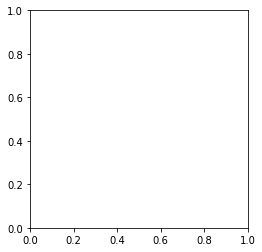

In [598]:
plt.imshow(a)

In [231]:
a.shape

(2496, 2625, 3)

In [191]:
(a[..., 2] == a[..., 1]).all()

True

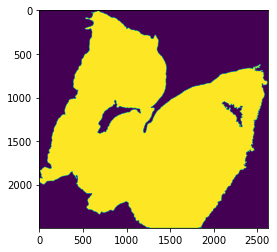

In [192]:
plt.imshow(a[..., 1] == 0)

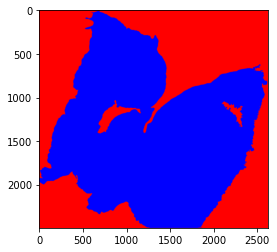

In [193]:
rgb = np.zeros_like(a)
rgb[a[..., 1] == 255] = [255, 0, 0] 
rgb[a[..., 1] == 0] = [0, 0, 255]
plt.imshow(rgb)

In [299]:
file_path = 'train_20230601/SegmentationClass/'
for mask in os.listdir(path):
    if file.endswith(".png")==True:
        m = cv2.imread(os.path.join(path, mask), -1)
        m = m[..., 0]
        m = m/ 255
        m = 1-m
        m = m.astype('uint8')
        cv2.imwrite(os.path.join(path, mask), m)

In [310]:
import matplotlib.pyplot as plt

In [311]:
b = cv2.imread('train_20230601/SegmentationClass/100000S01X2_IHC_17.png', -1)

In [312]:
b.shape

(512, 512)

In [314]:
np.bincount(b.reshape(-1))

array([ 56615, 205529])

In [315]:
rgb = np.zeros((512, 512, 3))
rgb[b==1] = [255,0,0]
rgb[b==0] = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


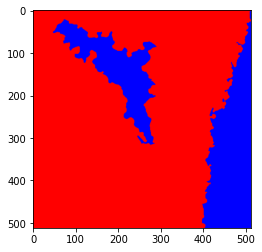

In [303]:
plt.imshow(b)